In [1]:
# multidimensional arrays
import numpy as np

# inline plots
import matplotlib.pyplot as plt
%matplotlib inline

# nicer figures
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Return to the origin


For a *finite* random walk of (large) length $n$, it is known that the expected number of returns to the origin $T_n$ scales like follows:
$$
\left\langle T_n \right\rangle \sim \left\{
\begin{array}{ll}
\sqrt{n} & d=1 \\
\log(n) & d=2 \\
C_d & d\geq 3
\end{array}
\right.
$$


<img src="attachment:image.png" width="600">

Notice that for $d \geq 3$, $\left\langle T_n \right\rangle$ does **not** grow with $n$, which must mean that the walker somehow "escapes" and never returns back to the origin. The probability of return to the origin is less than 1! For an infinite-length random walk, indeed the probability of returning to the origin $\rho$ is seen to be

$$
\rho \sim \left\{
\begin{array}{ll}
1 & d=1 \\
1 & d=2 \\
<1 & d\geq 3
\end{array}
\right.
$$

The *intuitive* explanation of this amazing fact is that, as the dimension $d$ grows, there are "more directions available", and so more chances for the walker to "get lost" and never return to the origin. There is of course a formal proof as well, but today we will do a **computational verification** of these facts, which is no substitute for a formal proof but is often all we can do!

## Generating Random Walks


### Exercise 3.1
Write a function that generates a random walk of given length in $d$ dimensions. Your random walker should move as follows:

+ At each time-step, the walker moves only in one direction.
+ At each time-step, the walker moves only by -1 or +1

Your function should return a numpy array of shape (`length`, `dim`). Example:
```python
>>> # create a RW of length 10 in dimension 3
>>> traj = get_traj(length=10, dim=3)
>>> # check that the output has the right shape
>>> traj.shape
(10, 3)
```

In [2]:
%%time
def get_traj(length:int, dim:int): #sto costruendo una matrice esempio: sull'asse delle x ho i tempi e per ogni tempo corrispondono dim ordinate
    steps=length
    position=np.zeros((length,dim)) #crea un vettore di 0 lungo quanto voglio
    #genero l'array delle direzioni, 
    dir_array=np.random.randint(dim, size=steps) #mi crea un vettore che per ogni step mi dice la direzione che sceglierò (asse su cui mi muovo)
    #genero il verso dello step
    updown_array=np.random.uniform(0, 1, size=steps) #mi dice il verso (faccio generare numeri distribuiti uniformemente tra 0 e 1 per ogni passo, a seconda del valore capisco se sto andando avanti o indietro)
    
    
    #faccio un upgrade delle posizioni
    # per ogni i definisco delle variabili locali dir e updown che prendono l'iesimo
    #componente di ogni vettore che mi serve per controllare direzione e verso, uso quesi valori per aggiornare la posizione
    for i in range(steps):
        dir = dir_array[i]
        updown=updown_array[i]
        position[i,:]=position[i-1,:] #vado avanti di uno step 
        #aggiorno la posizione, faccio un passo avanti o indietro
        if updown <0.5:
            position[i,dir]=position[i,dir]+1
        else:
            position[i,dir]=position[i,dir]-1
      
  #il ritorno di get_traj deve essere la posizione

    return position

Wall time: 0 ns


In [3]:
#prova
x=get_traj(length=10,dim=3)
print(x)
del x

[[ 1.  0.  0.]
 [ 1.  0. -1.]
 [ 1. -1. -1.]
 [ 0. -1. -1.]
 [ 0. -1. -2.]
 [ 0. -1. -1.]
 [ 0. -2. -1.]
 [ 0. -2.  0.]
 [ 0. -3.  0.]
 [ 0. -3. -1.]]


### Verification
To make sure that your function works correctly, execute the following cell. Notice the use of `assert` statements: execution should fail if something goes wrong. If everything is fine, nothing should happen.

In [4]:
# basic checks for your RW generator
#mi serve per controllare che funzioni, restituisca una cosa con una shape giusta
for dim in range(1, 5):
    for length in [10, 100, 200, 500]:
        traj = get_traj(length=length, dim=dim)
        # make sure traj has the right shape
        assert traj.shape == (length, dim)
        # make sure all steps are -1 or 1 in only one direction
        assert np.all(np.sum(np.diff(traj, axis=0) != 0, axis=1) == np.ones(length - 1))

### Exercise 3.2
Plot a random walk of length $10^4$ for $d=1$ (time in x-axis, position in y-axis) and $d=2$ (x,y components in x,y-axis). Remember to use **axis labels**.

In [5]:
# it is better if you use one cell to generate the random walks, and a second cell to plot them
length = 10000
RW_1d = get_traj(length,1)
RW_2d = get_traj(length,2)

Text(0.5, 1.0, '2D Random Walk')

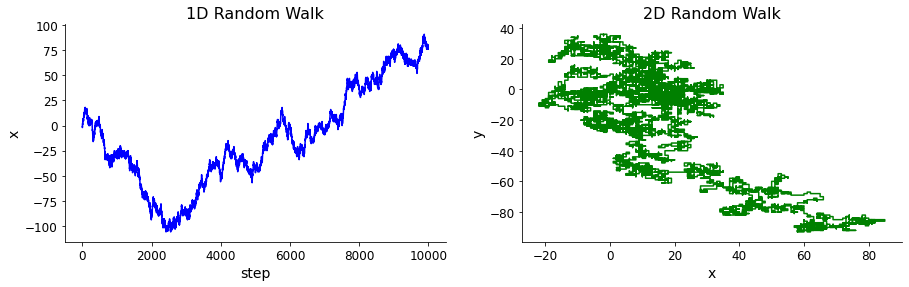

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

#definisco la variabile tempo che devo raappresentare sull'asse x
t=np.linspace(0, length, length) #ho length tempi che vanno da 0 a length

ax1.plot(t,RW_1d,color="blue")
ax2.plot(RW_2d[:,0], RW_2d[0:,1], color="green") #rappresento la prima coordinata sull'assex e la seconda sull'asse y


 # add labels for axes
ax1.set_xlabel('step')
ax1.set_ylabel('x')
        
# add title
ax1.set_title("1D Random Walk")
    


 # add labels for axes
ax2.set_xlabel('x')
ax2.set_ylabel('y')
        
# add title
ax2.set_title("2D Random Walk")

## Counting the number of returns to the origin
Since we are interested in how **the expected number of returns to the origin** scales with the RW length, we don't need to store the whole trajectory of each simulation (we will be performing many simulations!). 

### Exercise 3.3
Write a function that generates a RW of given length and dimension (calling `get_traj`), and returns the number of times it returned to the origin. To count the number of returns to the origin, you might need to use the following functions:
```python
np.all()
np.zeros()
np.count_nonzero()
```

In [7]:
def get_num_returns(length, dim):
    # generate a RW of given length and dimension
    pos = get_traj(length, dim)
    # count how many times it goes through the origin
    
    counter=np.zeros((length))
    for i in range (length):
        counter[i]=np.all(pos[i,:]==np.zeros((dim)))
    num_returns_to_origin=np.count_nonzero(counter==True) #somma 1 tutte le volte che il ritorno è nell'origine
    return num_returns_to_origin


In [8]:
#prova
x= get_num_returns(10**4, 2)
print(x)
del x

6


### Exercise 3.4
Write a function that computes the expected number of returns to the origin for a given length and dimension. Your function will call `get_num_returns()`, and should have an additional parameter that sets the sample size.

In [9]:
def get_average_num_returns(length, dim, num_trajs):
    
    returns=np.zeros(num_trajs)
    
    for i in range(num_trajs):
        returns[i] = get_num_returns(length, dim)
    
    average_num_returns = np.average(returns)
    
    return average_num_returns

In [10]:
#prova
x=get_average_num_returns(1000, 2, 200)
print(x)
del x

1.97


## Comparing with analytical results
We are now ready to compare our analytical results with numerical simulations! We want to plot the expected number of returns to the origin as a function of the RW length. To do this, it is useful to first define an array of RW lengths.

In [11]:
# define range of RW lengths
length_min = 10
length_max = 100000
# generate points logarithmically spaces
# and convert them to integers
length_array = np.array([
    int(x)
    for x in np.geomspace(length_min, length_max, num=20)
])

(tip: if your RW generating function is not very efficient, you might want to decrease `length_min`)  

Executing the following cell will run all simulations for $d=1$


In [12]:
%%time

dim=1
num_trajs = 100
num_returns_array = np.array([
    get_average_num_returns(length=length, dim=dim, num_trajs = num_trajs)
    for length in length_array
])

Wall time: 2min 45s


### Exercise 3.5
Plot the average number of returns to the origin of a 1D RW as a function of the RW length, together with the expected theoretical result. Do your results verify the $n^{1/2}$ scaling? **Tip** Use double-logarithmic scales in your plot. Remember to include label axis, and a legend!

Wall time: 20.7 ms


Text(0.5, 1.0, 'Confronto scaling')

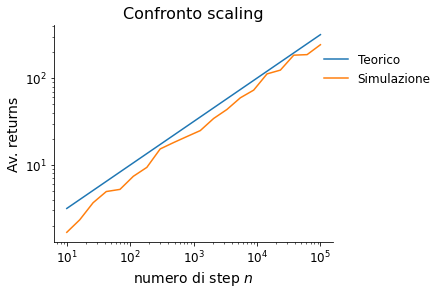

In [13]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
teoria=np.sqrt(length_array)

# plot theoretical result
ax.loglog(length_array, teoria, label="Teorico")

# plot numerical result
ax.loglog(length_array, num_returns_array, label="Simulazione")

# add axis labels
ax.set_xlabel(r"numero di step $n$")
ax.set_ylabel(r"Av. returns")

# add legend
ax.legend(loc=(0.95, 0.7), frameon=False)

# add a title (e.g. that says what dimension we used)
ax.set_title("Confronto scaling");

### Exercise 3.6
Plot the average number of returns to the origin of a 2D RW as a function of the RW length. Do your results verify the $log(n)$ scaling? What are the best axis scales to use in this case?

In [67]:
%%time 
#DIMENSIONE 2

dim=2
num_returns_array = np.array([
    get_average_num_returns(length=length, dim=dim, num_trajs=100)
    for length in length_array
]);

Wall time: 3min 35s


Wall time: 27.3 ms


Text(0.5, 1.0, 'Random-Walk scaling in 2D')

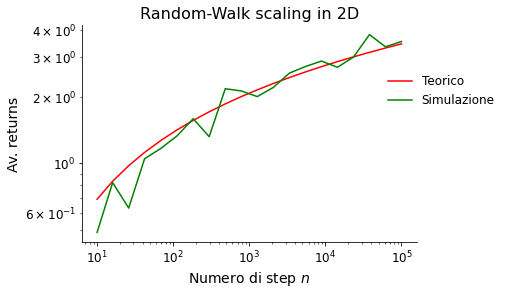

In [68]:
%%time

# plot the numerical results + theory
fig, ax = plt.subplots(1,1, figsize=(6,4))

theory=np.log(length_array)*0.3

#teorico
ax.loglog(length_array, theory, color='red', label="Teorico")
#simulazione
ax.plot(length_array, num_returns_array, color='green', label="Simulazione")

# add axis labels
ax.set_xlabel('Numero di step $n$')
ax.set_ylabel('Av. returns')

# add a legend
ax.legend(loc=(0.9,0.6),frameon=False)

# add a title (e.g. that says what dimension we used)
ax.set_title(f'Random-Walk scaling in {dim}D')

### Exercise 3.7
Show numerically that, for $d=3$ and $d=4$, the expected number of returns to the origin is **constant**.

In [69]:
%%time
#DIMENSIONE 3

dim=3
num_returns_array=np.array([
    get_average_num_returns(length=length, dim=dim, num_trajs=1000)
    for length in length_array
]);

Wall time: 36min 26s


Wall time: 24.8 ms


Text(0.5, 1.0, 'Random-Walk scaling in 3D')

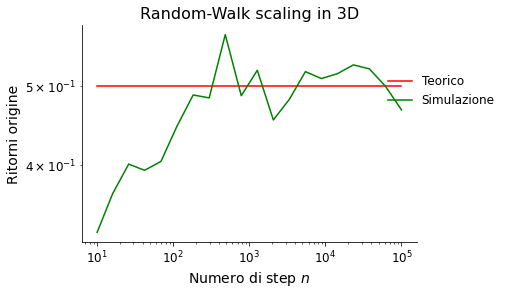

In [70]:
%%time

#plot
fig, ax = plt.subplots(1,1, figsize=(6,4))

theory=np.ones(len(length_array))*0.5

#teorico
ax.loglog(length_array, theory, color='red', label="Teorico")
#simulazione
ax.plot(length_array, num_returns_array, color='green', label="Simulazione")

# add axis labels
ax.set_xlabel('Numero di step $n$')
ax.set_ylabel('Ritorni origine')

# add a legend
ax.legend(loc=(0.9,0.6),frameon=False)

# add a title (e.g. that says what dimension we used)
ax.set_title(f'Random-Walk scaling in {dim}D')

In [73]:
%%time
#DIMENSIONE 4

dim=4
num_returns_array=np.array([
    get_average_num_returns(length=length, dim=dim, num_trajs=100)
    for length in length_array
]);

Wall time: 2min 27s


Wall time: 28.6 ms


Text(0.5, 1.0, 'Random-Walk scaling in 4D')

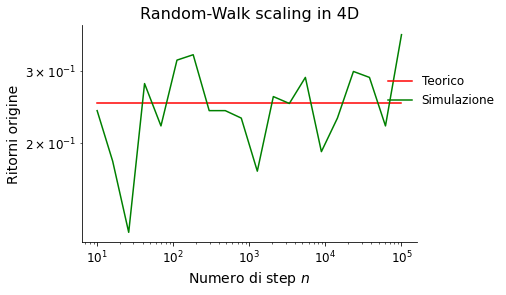

In [75]:
%%time

#plot
fig, ax = plt.subplots(1,1, figsize=(6,4))

theory=np.ones(len(length_array))*0.25
#teorico
ax.loglog(length_array, theory, color='red', label="Teorico")
#simulazione
ax.plot(length_array, num_returns_array, color='green', label="Simulazione")

# add axis labels
ax.set_xlabel('Numero di step $n$')
ax.set_ylabel('Ritorni origine')

# add a legend
ax.legend(loc=(0.9,0.6),frameon=False)

# add a title (e.g. that says what dimension we used)
ax.set_title(f'Random-Walk scaling in {dim}D')

# Self-Avoiding Walks
Self-avoiding walks (SAW) are simply random walks in a regular lattice with the additional constraint that no point can be visited more than once. That is, SAWs cannot intersect themselves. The most well-known application of SAW is to model linear polymers, where obviously two monomers cannot occupy the same space (excluded volume effect).


You can read more about self-avoiding walks in this nice introduction by Gordon Slade:

[Self-Avoiding Walks, by Gordon Slade](https://www.math.ubc.ca/~slade/intelligencer.pdf)

## Simulating Self-Avoiding Walks
Generating a SAW is not trivial. If you try to generate a SAW stochastically, that is, one step at a time, you will miserably fail: your walker might get into traps (configurations with no allowed movements), and if it does you will have to discard your simulation. It turns out you will have to discard your simulation *really* often, so that for large lengths, you will basically never find a valid path. In addition, the paths you will find for short lengths will not come up with the right probabilities. Bear in mind that we want to **uniformly sample** the set of SAW of given length $n$, SAW($n$). That is, we want that all paths from SAW($n$) are generated with the same probability.

The solution is to use a Monte Carlo algorithm that, given one element $\alpha \in \text{SAW}(n)$, generates a new one $\beta \in \text{SAW}(n)$ with some probability $P_{\alpha \beta}$. If in addition our algorithm satisfies **detailed balance** and is **ergodic**, then we known that it will converge to the equilibrium distribution (the uniform distribution in our case).


## The pivot algorithm
We will implement the pivot algorithm, which is simple, effective, and satisfies detailed balance and ergodicity. You can read about the details of the pivot algorithm here:

[The Pivot Algorithm: A Highly Efficient Monte Carlo Method for the Self-Avoiding Walk](https://link.springer.com/article/10.1007/BF01022990)

(tip: if you're at home, **do not** use tools such as sci-hub to download the paper).

Given a self-avoiding walk of length $n$, the pivot algorithm generates the next walk $\beta \in \text{SAW}(n)$ as follows:

1. **Choose a point of $\alpha$ at random**, splitting the path in two bits: the head (from the origin to the chosen point) and the tail (from the chosen point to the end of the path). Notice that both the head and the tail are SAWs.
2. **Apply a transformation to the tail**, leaving the head intact. The transformation must be an orthoganl transformation that leaves the regular lattice intact (so, either a reflection or a $90º, 180º$ or $270º$ rotation). For simplicity, we will use only **rotations** (read the paper to see why this is ok).
3. **Check if the new path is self-avoiding**. If so, return it. Otherwise, return the original path.

Iterating these steps one obtains a **Markov** chain of SAWs: $\alpha_1 \to \alpha_2 \to \dots \to \alpha_M $. Notice that $\alpha_i$ are not uncorrelated, but because the algorithm satisfies detailed balance and is ergodic, we know that it approaches the equilibrium distribution. This means that we can use our Markov chain to compute **expected values** as long as it is long enough.

## Implementing the pivot step in 2D
To implement the **pivot algorithm** in 2D, we will write one function that does steps 1 and 2, and another function that does step 3. We will also need a function to generate standard 2D random walks.

### Exercise 3.8
Write a function `get_traj` that generates a 2D random walk of given length.

In [76]:
def get_traj(length):
    """Generate a 2D random walk of given length"""
    dim = 2
    steps=length
    position=np.zeros((length,dim)) #crea un vettore di 0 lungo quanto voglio
    #genero l'array delle direzioni, 
    dir_array=np.random.randint(dim, size=steps) #mi crea un vettore che per ogni step mi dice la direzione che sceglierò (asse su cui mi muovo)
    #genero il verso dello step
    updown_array=np.random.uniform(0, 1, size=steps) #mi dice il verso (faccio generare numeri distribuiti uniformemente tra 0 e 1 per ogni passo, a seconda del valore capisco se sto andando avanti o indietro)
    
    
    #faccio un upgrade delle posizioni
    # per ogni i definisco delle variabili locali dir e updown che prendono l'iesimo
    #componente di ogni vettore che mi serve per controllare direzione e verso, uso quesi valori per aggiornare la posizione
    for i in range(steps):
        dir = dir_array[i]
        updown=updown_array[i]
        position[i,:]=position[i-1,:] #vado avanti di uno step temporale
        #aggiorno la posizione, faccio un passo avanti o indietro
        if updown <0.5:
            position[i,dir]=position[i,dir]+1
        else:
            position[i,dir]=position[i,dir]-1

    return position

In [77]:
#prova
position=get_traj(5)
print(position)
del position

[[ 0. -1.]
 [-1. -1.]
 [-2. -1.]
 [-2. -2.]
 [-1. -2.]]


### Exercise 3.9
Write a function `pivot_traj` that, given a 2D random walk, performs steps 1 and 2 of the pivot algorithm. Some useful functions:
```python
np.random.randint()
np.concatenate()
```
You might also want to multiply matrices using the `@` operator:
```python
>>> a = np.array([[1, 2], [3, 4], [5, 6]])
>>> b = np.array([1, 1])
>>> a @ b
array([ 3,  7, 11])
```


In [78]:
def pivot_traj(traj):
    """Apply a random rotation to part of a RW."""
    
    length, columns=traj.shape
    
    # choose the pivot
    pivot_index = np.random.randint(1,length)
    pivot_point = traj[pivot_index,:]
    

    # split head and tail
    traj_head = np.array([traj[i,:] for i in range (pivot_index)])
    traj_tail = np.array([traj[pivot_index+i,:] for i in range(length-pivot_index)])
    mvd_tail =np.subtract(traj_tail,traj[pivot_index-1,:])
    
    # define the rotation matrices 
    symmetries = [
        # 90 deg rotation
        np.array([[0 ,1 ], [-1 , 0]]),
        # 180 deg rotation
        np.array([[-1 ,0 ], [0 ,-1 ]]),
        # 270 deg rotation
        np.array([[0 ,-1 ], [1 ,0 ]]),
    ]
    
    # choose one rotation at random
    symmetry = symmetries[np.random.randint(0,3)]
    
    # apply the transformation to the tail
    rot_tail = mvd_tail@symmetry
    new_tail=np.add(rot_tail,traj[pivot_index-1,:])
      
    # join the old head with the new tail
    new_traj = np.concatenate((traj_head, new_tail), axis=0)
    
    return new_traj

### Exercise 3.10
Write a function that counts the number of self-intersections of a RW. Notice that SAWs have 0 self intersections, so that will solve step 3 of the pivot algorithm, but will also be useful to generate the initial condition. One way of approaching this exercise is to count how many *different* points the path visits.

In [80]:
def count_self_intersections(position):
    """Count the number of self-intersections of a RW"""
    self_int = np.zeros(len(position))
    
    for i in range(len(position)):
        for j in range(len(position)):
            if position[i,0]==position[j,0] and position[i,1]==position[j,1]:
                self_int[i]+=1
    
    num_inters=0
    for i in range(int(np.amax(self_int)-1)):
        num_inters+=int(np.count_nonzero(self_int==i+2)/(i+2))
          
    return num_inters

count_self_intersections(traj)

84

### Exercise 3.11
Verify that your `count_self_intersecitons` function works properly by using short trajectories for which you know the answer.

In [81]:
traj=get_traj(10)
print(traj)
print(count_self_intersections(traj))

piv_traj=pivot_traj(traj)
print(piv_traj)
print(count_self_intersections(piv_traj))

del traj
del piv_traj

[[ 1.  0.]
 [ 1.  1.]
 [ 1.  0.]
 [ 1.  1.]
 [ 1.  2.]
 [ 0.  2.]
 [ 0.  1.]
 [-1.  1.]
 [ 0.  1.]
 [ 0.  0.]]
3
[[ 1.  0.]
 [ 1.  1.]
 [ 1.  0.]
 [ 1. -1.]
 [ 1. -2.]
 [ 2. -2.]
 [ 2. -1.]
 [ 3. -1.]
 [ 2. -1.]
 [ 2.  0.]]
2


## Generating the initial condition
You might have noticed that the pivot algorithm requires an element of SAW($n$) as starting condition, to then generate a Markov chain easily. But how do you get this first element? We will use the following strategy:
1. Generate a standard 2D random walk, and count the number of self intersections.
2. Apply the pivot transformation to get a new 2D random walk, and count the number of self-intersections-
3. If the number of self-intersections has decreased or not changed, keep the new path. Else, keep the old one.
4. Go to 2, till the number of self-intersections is 0.

### Exercise 3.12
Write a function `get_first_SAW` that generates a SAW of given length

In [82]:
def get_first_SAW(length, max_tries=1000000):
    
    traj=get_traj(length)
    self_in=count_self_intersections(traj)
    
    i=1
    while i<=max_tries and self_in!=0:
        new_traj=pivot_traj(traj)
        new_si=count_self_intersections(new_traj)
        if new_si<= self_in:
            self_in=new_si
            traj=new_traj
        i+=1
        
    assert self_in==0
    
    return traj

### Exercise 3.13
Generate and plot some 2D SAWs of different lengths. Be carefull, raise the length slowly! You can measure how long a cell takes executing using the `%%time` magic at the top of a cell.

Wall time: 3min 28s


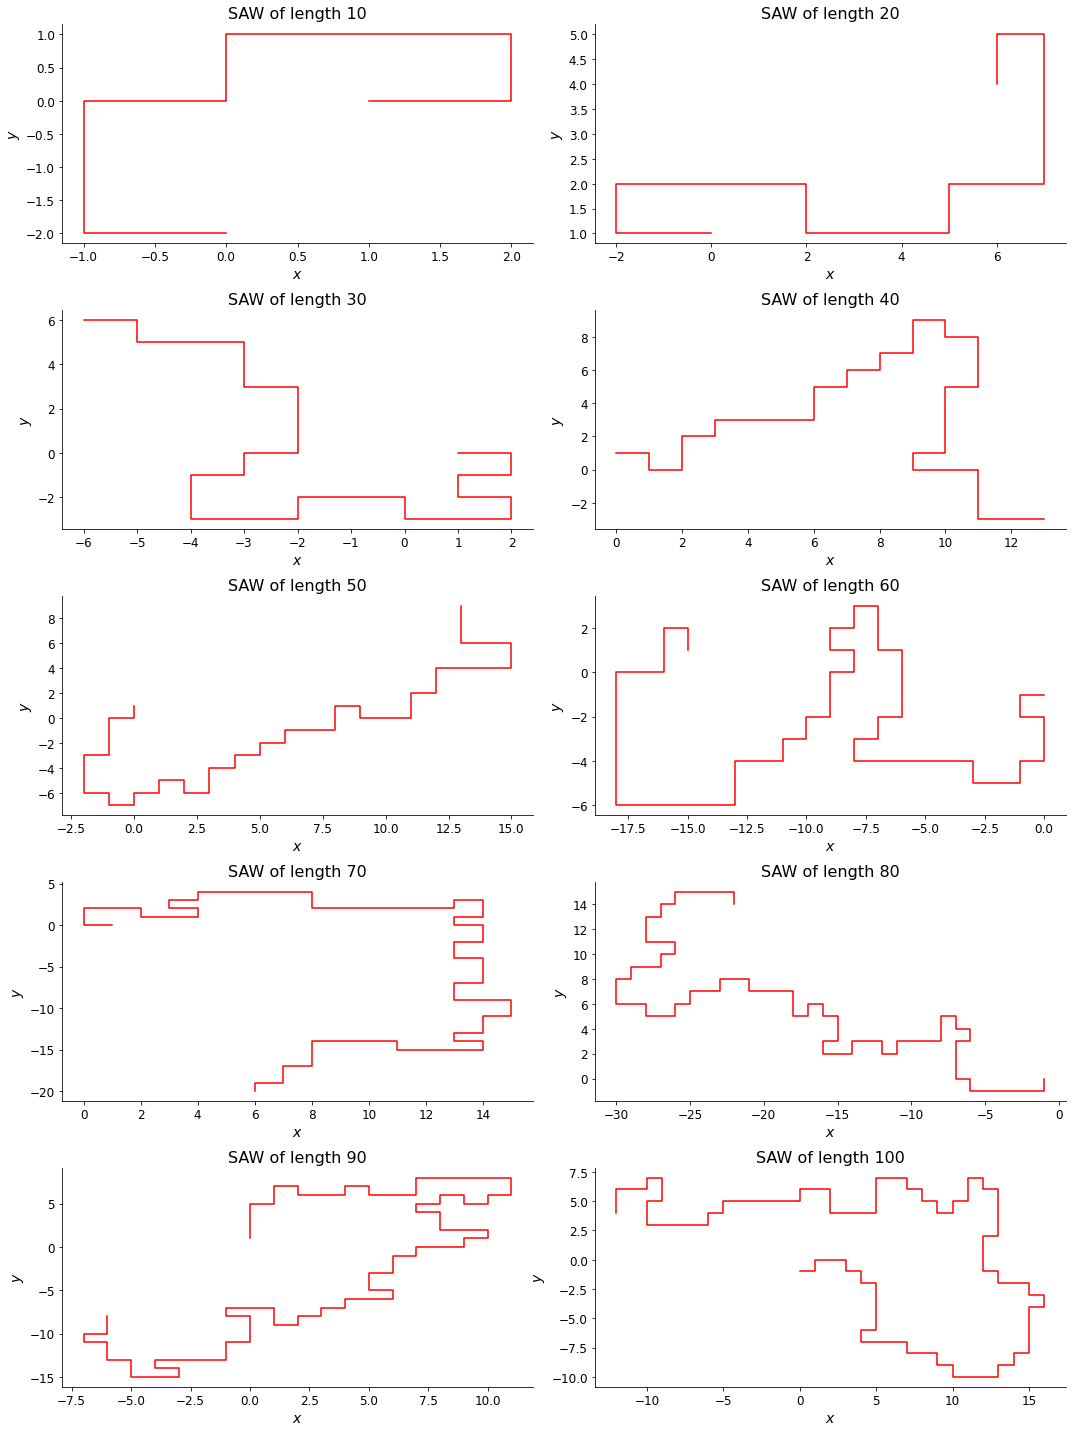

In [107]:
%%time

n_saws=10
length=10
columns=2
rows=int(n_saws/2)
fig, axx=plt.subplots(rows,columns, figsize=(15,20), tight_layout=True)
axx=axx.reshape(-1)
for i in range (n_saws):
    saw=get_first_SAW(length+i*10)
    ax=axx[i]
    ax.plot(saw[:,0], saw[:,1], color='red', label='saw')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'SAW of length {length+i*10}')

### Exercise 3.14
Write a function `get_next_SAW` that, given a SAW, generates another SAW using the pivot algorithm. Your function should check that the input RW is really a SAW. Remember the steps:

1. Apply the pivot transformation
2. Check if the new path is self-avoiding. **If so, return it. Otherwise, return the original path.**

In [83]:
def get_next_SAW(traj):
    # make sure input traj is SAW
    assert count_self_intersections(traj)==0
    
    # pivot step
    hyp_traj = pivot_traj(traj)
    
    # count intersections
    self_in = count_self_intersections(hyp_traj)
    
    # if it's a SAW
    if self_in==0:
        return hyp_traj
    
    # if not
    else:
        return traj

### Mean Squared Displacement in SAW
A quantity of interest in RWs is the mean squared displacement, which is simply the (squared) distance between the endpoints of the walk. Usually, one writes

$$
\left\langle X(n)^2 \right\rangle \sim n^{2 \nu}
$$

As you know, for a standard RW of $n$ steps, the mean-squared displacement scales like $n$, so $\nu=1/2$. However, the exponent for SAW is **different**! Althought it has not been formally proven (still), it is believed that the exponent for SAW is $\nu=3/4$. That is, for a self-avoiding random walk, the mean squared displacement scales as $n^{3/2}$.

### Exercise 3.15
Explain why it makes sense that the mean-squared displacement exponent of SAW is **greater** than that of standard RW. 

Dato che lo scarto quadratico medio della posizione finale in un random walk indica quanto il walker si è spostato dall origine, intuitivamente è corretto che questa grandezza sia maggiore per cammini SAW piuttosto che per random walk ordinari perchè per i SAW, non potendo percorre uno stesso tratto a ritroso, la probabilità di toranre indietro (tornare verso l origine) è inferiore rispetto a quella di di andare avanti

### Exercise 3.16
Verify numerically the scaling of the mean-squared displacement of SAW. Notice that you don't need to store all the SAWs, just the endpoints. You could follow this scheme:

1. Generate a first SAW with your `get_first_SAW()` function
2. Generate the next SAW using your `get_next_SAW()` function, and store the endpoint.
3. Iterate step 2 for as many steps as required
4. Compute the average mean-squared displacement of the stored endpoints

Then repeating steps 1-4 for different lengths, and plot the results in double-logarithmic axis. Compare your results with the theoretical exponent. Do they agree?

In [88]:
import math
minstep=10
K=4 
N=10

length_array=np.array([10+minstep*j*3 for j in range (K)]) 
#genero un array in cui immagazzinare il numero di step che voglio vengano compiuti a ciascuna iterazione
#parto da un minimo di step di 10 passi

mean_sq=np.zeros((K))
end=np.zeros((N))

In [89]:
%%time

i=0
length=length_array[i]

first_saw=get_first_SAW(length) #genero una prima SAW
for l in range (N):
    saw=get_next_SAW(first_saw)
    end[l]=np.sqrt(saw[length-1,0]**2)+(saw[length-1,1]**2)
    
mean_sq[i]=np.var(end)

del saw
del first_saw

Wall time: 7.97 ms


In [90]:
%%time

i=1
length=length_array[i]

first_saw=get_first_SAW(length) #genero una prima SAW
for l in range (N):
    saw=get_next_SAW(first_saw)
    end[l]=np.sqrt(saw[length-1,0]**2)+(saw[length-1,1]**2)
    
mean_sq[i]=np.var(end)

del saw
del first_saw

Wall time: 2.61 s


In [91]:
%%time

i=2
length=length_array[i]

first_saw=get_first_SAW(length) #genero una prima SAW
for l in range (N):
    saw=get_next_SAW(first_saw)
    end[l]=np.sqrt(saw[length-1,0]**2)+(saw[length-1,1]**2)
    
mean_sq[i]=np.var(end)

del saw
del first_saw

Wall time: 1min 51s


In [92]:
%%time

i=3
length=length_array[i]

first_saw=get_first_SAW(length) #genero una prima SAW
for l in range (N):
    saw=get_next_SAW(first_saw)
    end[l]=np.sqrt(saw[length-1,0]**2)+(saw[length-1,1]**2)
    
mean_sq[i]=np.var(end)

del saw
del first_saw

Wall time: 5min 5s


Wall time: 34.2 ms


Text(0.5, 1.0, 'Mean Squared Displacement')

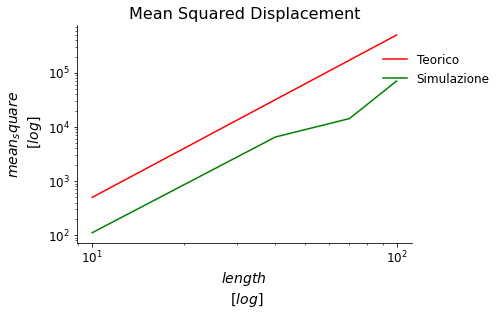

In [93]:
%%time

# plot the numerical results + theory
fig, ax = plt.subplots(1,1, figsize=(6,4))

theory=np.log(length_array)*0.3

#teorico
ax.loglog(length_array, length_array**3/2, color='red', label="Teorico")
#simulazione
ax.loglog(length_array, mean_sq, color='green', label="Simulazione")

# add axis labels
ax.set_xlabel('$length$ \n $[log]$')
ax.set_ylabel('$mean_square$ \n $[log$]')

# add a legend
ax.legend(loc=(0.9,0.7),frameon=False)

# add a title (e.g. that says what dimension we used)
ax.set_title('Mean Squared Displacement')